In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from init_objects import *
from hft_model import *

# Enforcing the speed limit replication notebook

In [2]:
NRUNS = 1

In [19]:
parameters = {
    # global parameters
    "n_lft": 200,
    "n_hft": 4,
    "ticks": 600, # 390 ticks per day
    "fundamental_value": 10,
    "lft_sample_size": 0.05,
    "hft_sample_size": 1.0,
    "std_noise": 0.01,
    "std_LFT_price": 0.01,
    "std_LFT_vol": 4,
    "std_HFT_vol": 4,
    "return_on_investment": 0.5,
    "investment_frequency": 5000,
    "max_order_expiration_ticks": 30,
    # lft parameters
    "w_fundamentalists": 2.0, #1
    "w_chartists": 1.4, # 10
    "w_random": 4,
    "spread_max": 0.25,
    # hft parameters
    "inventory_target": 1,
    "minimum_price_increment": 0.001,
    "investment_fraction": 0.00,
    "hfm_risk_aversion": 25,
    "hfm_fixed_vol": 1,
    # initial values
    "wealth": 300,
    "horizon_min": 1,
    "horizon_max": 4,
    "av_return_interval_max": 4,
    "init_price": 1,
    "agent_order_price_variability": (1, 1),
    "total_hft_money": 2000,
    "hft_speed": 1,
    "hft_init_investment": 0
}

# Initialisation

In [20]:
# 1 initalise model objects
high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)

# Simulation

In [21]:
#%%timeit
for seed in range(NRUNS):
    high_frequency_traders, low_frequency_traders, orderbook = hft_model(high_frequency_traders, low_frequency_traders, orderbook, parameters, seed)

0.139152748252
0.140152748252
0.192593376781
0.193593376781
1.94341461876
1.94441461876
0.0942549013261
0.0952549013261
1.0024214189
1.0024214189
1.0034214189
0.826539797348
0.827539797348
1.34163953491
1.34163953491
1.34263953491
0.672178910541
0.673178910541
0.569711429892
0.570711429892
-3.66670722199
-3.66670722199
-3.66570722199
0.0472776732051
0.0482776732051
0.895424878099
0.498884578076
0.500884578076
0.898424878099
0.250071850416
0.250071850416
0.251071850416
1.60078473378
1.60078473378
1.60078473378
3.69026813226
3.69170471206
1.60378473378
0.245255523185
4.28420510102
4.28420510102
3.37467145201
3.37467145201
0.248255523185
1.9751701103
1.9761701103
1.9771701103
0.525860467008
0.526860467008
0.527860467008
0.175834519287
0.175834519287
0.175834519287
0.949186472625
3.29438863546
3.29538863546
0.340951054141
0.517730540576
5.8647258949
3.40143849352
2.18359133435
5.8677258949
2.92258103133
2.92358103133
2.92458103133
2.92558103133
0.108181333216
0.109181333216
0.110181333216


# Data analysis

In [22]:
average_tick_price = [np.mean(prices) for prices in orderbook.transaction_prices_history]
total_tick_volume = [sum(volumes) for volumes in orderbook.transaction_volumes_history]
returns = pd.Series(np.array(average_tick_price)).pct_change()
autocorr_returns = [pd.Series(returns).autocorr(lag=lag) for lag in range(25)]
absolute_returns = pd.Series(returns).abs()
autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(25)]

## Prices, returns & volume

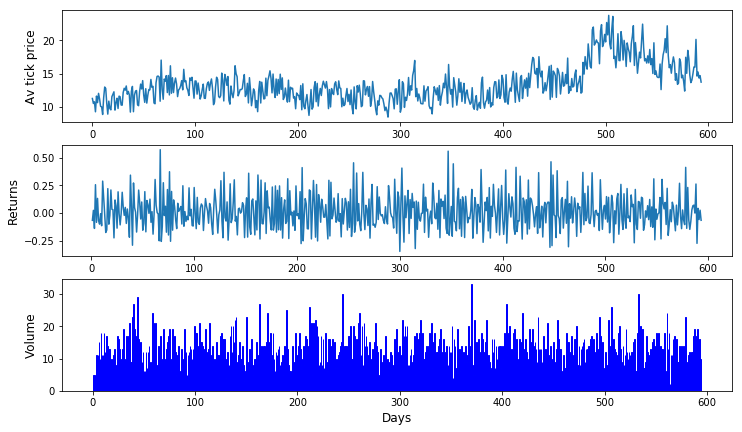

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,7))

ax1.plot(range(len(average_tick_price)), average_tick_price)
ax1.set_ylabel('Av tick price', fontsize='12')

ax2.plot(range(len(returns)), returns)
ax2.set_ylabel('Returns', fontsize='12')

ax3.bar(range(len(total_tick_volume)), total_tick_volume, edgecolor='b')
ax3.set_ylabel('Volume', fontsize='12')
ax3.set_xlabel('Days', fontsize='12')

for ax in [ax1, ax2, ax3]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

## Bid-ask spread & volatility

In [24]:
bid_ask = [ask - bid for bid, ask in zip(orderbook.highest_bid_price_history, orderbook.lowest_ask_price_history)]
bid_ask = list(filter(lambda x: x >0, bid_ask))
np.mean(bid_ask)

0.74242103255864056

In [25]:
# is this the correct way 
window = 10
roller_returns = returns.rolling(window)
returns_volatility = roller_returns.std(ddof=0)
returns.std()

0.16073600747148645

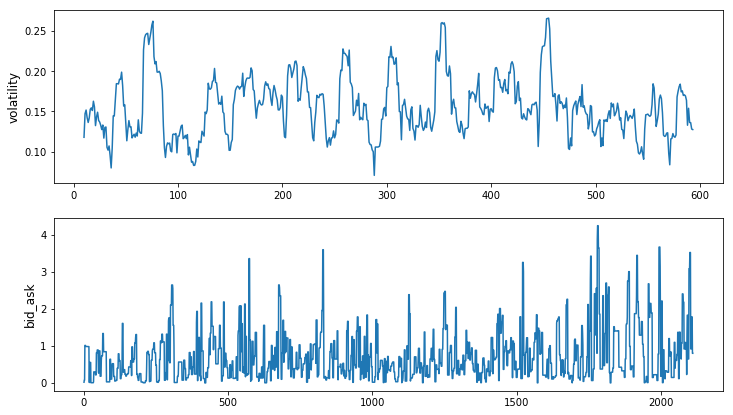

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7))

ax1.plot(range(len(returns_volatility)), returns_volatility)
ax1.set_ylabel('volatility', fontsize='12')

ax2.plot(range(len(bid_ask)), bid_ask)
ax2.set_ylabel('bid_ask', fontsize='12')

# Basic financial market stylized facts
## No autocorrelation in returns

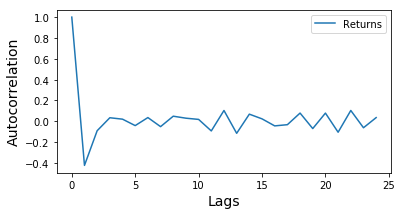

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.plot(range(len(autocorr_returns)), autocorr_returns, label='Returns')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lags', fontsize='14')
#fig.savefig('auto_correlation.png')

## Excess Kurtosis

In [28]:
pd.Series(returns).kurtosis()

-0.0013976177158356862

## Clustered volatility

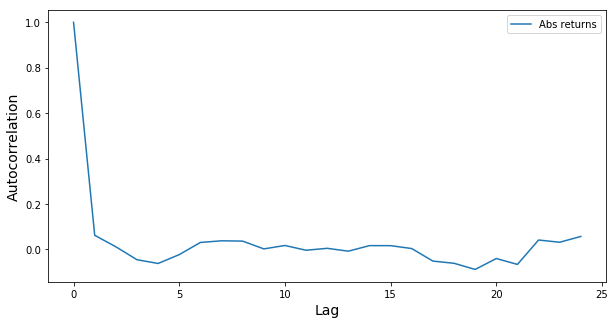

In [29]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(autocorr_abs_returns)), autocorr_abs_returns, label='Abs returns')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')
#fig.savefig('auto_correlation_abs.png')

# HFT Investment

In [30]:
cum_inv = []
for hft in high_frequency_traders:
    cum_inv.append(np.array(hft.var_previous.cum_investment))

In [31]:
agg_cum_inv = np.zeros(len(cum_inv[0]))
for c_i in cum_inv:
    agg_cum_inv += c_i

C:\Users\joerischasfoort\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


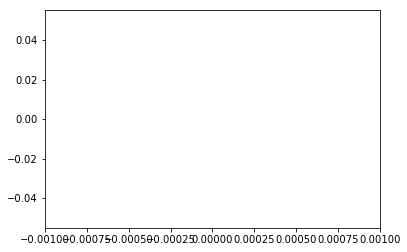

In [32]:
pd.Series(agg_cum_inv)[:100].plot()

# HFT speed

In [33]:
speed = []
for hft in high_frequency_traders:
    speed.append(np.array(hft.var_previous.speed))

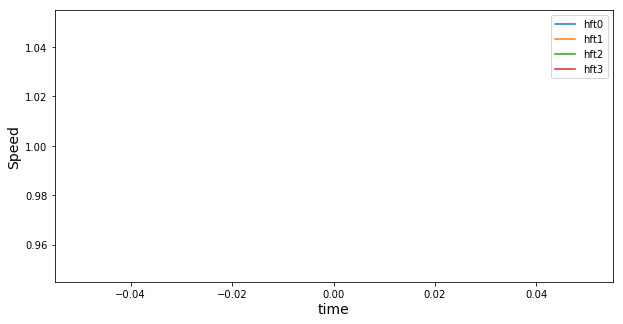

In [34]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

for idx, s in enumerate(speed):
    ax1.plot(range(len(s[:100])), s[:100], label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Speed', fontsize='14')
ax1.set_xlabel('time', fontsize='14')
#fig.savefig('auto_correlation_abs.png')

# HFT profitability

Total wealth. The HFT's track their own total wealth

In [35]:
money = []
stocks = []
locked_in_profits = []
for hft in high_frequency_traders:
    money.append(np.array(hft.var_previous.money))
    stocks.append(np.array(hft.var_previous.stocks))
    locked_in_profits.append(np.array(hft.var_previous.locked_profit))

### Locked in profits

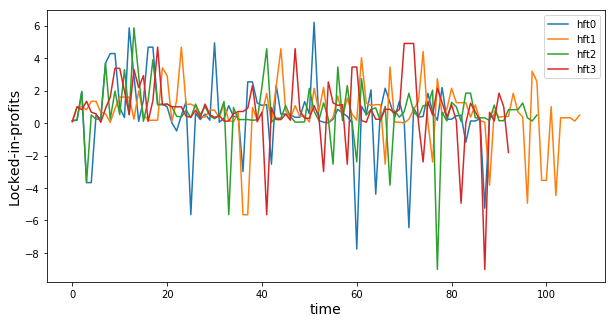

In [36]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

for idx, p in enumerate(locked_in_profits):
    ax1.plot(range(len(p)), p, label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Locked-in-profits', fontsize='14')
ax1.set_xlabel('time', fontsize='14')

In [37]:
sum(locked_in_profits[0])

48.846796469789275

### Sharpe ratio

In [38]:
def sharpe(periods, mean, standard_deviation):
    return np.sqrt(periods) * (mean / standard_deviation)

In [39]:
sharpe(len(locked_in_profits[0]), locked_in_profits[0].mean(), locked_in_profits[0].std())

2.2652516112110357

### Wealth

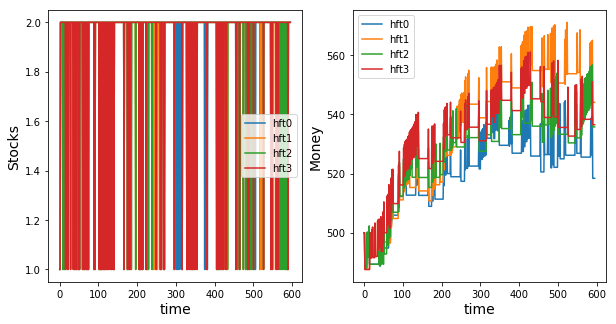

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

timeframe = 10000

for idx, s in enumerate(stocks):
    ax1.plot(range(len(s[:timeframe])), s[:timeframe], label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Stocks', fontsize='14')
ax1.set_xlabel('time', fontsize='14')

for idx, m in enumerate(money):
    ax2.plot(range(len(m[:timeframe])), m[:timeframe], label='hft{}'.format(idx))

ax2.legend(frameon=True, loc='best', framealpha=0.8)
ax2.set_ylabel('Money', fontsize='14')
ax2.set_xlabel('time', fontsize='14')
#fig.savefig('auto_correlation_abs.png')

# Orderbook depth

size of ask book? Size of bids book?

In [24]:
np.random.normal(scale=parameters['std_LFT_price'])

0.004313224404561005

# Percentage of trades by HFT vs. LFT? 